# Project01
# <네이버 영화 리뷰 감성 분류에 SentencePiece 적용해보기>

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

# 1.데이터 다운로드

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow import keras
import sentencepiece as spm
import tensorflow as tf
import urllib.request
import pandas as pd
import numpy as np
import csv
import re

In [ ]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!tar -xzvf korean-english-park.train.tar.gz

--2022-03-18 11:55:03--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-03-18 11:55:04--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

     |████████████████████████████████| 19.4 MB 1.6 MB/s 
     |████████████████████████████████| 448 kB 9.4 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 10.48 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-03-18 11:55:20--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

In [ ]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7fbc9be609d0>)

# 2.데이터 정제

## 데이터 준비

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

display(train_data)
print()
display(test_data)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
print("train_data 데이터 갯수 : ", len(train_data), '개')
print()
print("test_data 데이터 갯수 : ", len(test_data), '개')

train_data 데이터 갯수 :  150000 개

test_data 데이터 갯수 :  50000 개


## 중복, 결측치, 불용어 제거

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

# 한글만 쓰자
train_data['document'] = train_data['document'].replace('[^가-힣 ]', '')
test_data['document'] = test_data['document'].replace('[^가-힣 ]', '')

# 중복 나가라
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

# Nan 결측치는 사라져라
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')
print("train_data 결측치 확인 - ", train_data.isna().sum())
print("test_data 결측치 확인 - ", test_data.isna().sum())

display(train_data)
print()
display(test_data)

train_data 결측치 확인 -  id          0
document    0
label       0
dtype: int64
test_data 결측치 확인 -  id          0
document    0
label       0
dtype: int64


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


# 3.SentencePieceProcessor

In [ ]:
vocab_size = 10000
temp_file = 'korean-english-park.train.ko'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)
)

In [ ]:
# vocab을 불러오기
vocab_list = pd.read_csv('korean_spm.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.head(10)

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,.,-3.41161
4,▁,-3.51653
5,을,-3.86357
6,의,-3.92848
7,에,-4.28122
8,를,-4.28425
9,이,-4.35286


In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

stop_df = pd.read_csv('한국어불용어100.txt', sep = '\t', header = None, names = ['형태','품사','비율'])
stop_df.tail()

,형태,품사,비율
95,원,NNB,0.000492
96,잘,MAG,0.000491
97,통하,VV,0.000487
98,소리,NNG,0.000486
99,놓,VX,0.000483


In [ ]:
stopwords = stop_df.형태
type(stopwords)
stopwords_list = []
for i in stopwords:
    stopwords_list.append(str(i))
print(stopwords_list)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load('korean_spm.model')

True

In [ ]:
# 불용어 제거 후 다시 널어주는 함수
def clean_stopword(data, stopwords_list):
    sentence_list = []
    for sentence in data:
        not_stopword = []
        for word in sentence:
            if word in stopwords_list:
                continue
            elif word == ' ':
                continue
            elif word == 'ㅋ':
                continue
            else:
                not_stopword.append(word)
        # print(not_stopword)
        sentence_list.append(not_stopword)
    print(sentence_list)
    data = sentence_list

    return sentence_list

# 불용어 너도 나가
sentence_train = clean_stopword(train_data['document'], stopwords_list)
sentence_test = clean_stopword(test_data['document'], stopwords_list)

# 빈 값 처리
train_data['document'] = train_data['document'].replace(' ', '')
test_data['document'] = test_data['document'].replace(' ', '')

display(train_data)
print()
display(test_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
def sp_tokenize(sp, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(sp.EncodeAsIds(sen)) # EncodeAsIds: ids으로 tokenize 후 정수화

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
    print("vocab", vocab)

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})  # 딕셔너리 값 변경
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [ ]:
tensor_train, word_index_train, index_word_train = sp_tokenize(sp, train_data['document'])
tensor_test, word_index_test, index_word_test = sp_tokenize(sp, test_data['document'])

vocab ['<unk>\t0\n', '<s>\t0\n', '</s>\t0\n', '.\t-3.41161\n', '▁\t-3.51653\n', '을\t-3.86357\n', '의\t-3.92848\n', '에\t-4.28122\n', '를\t-4.28425\n', '이\t-4.35286\n', '는\t-4.37411\n', '가\t-4.47615\n', ',\t-4.53876\n', '은\t-4.59335\n', '고\t-4.67322\n', '에서\t-5.0279\n', '로\t-5.09797\n', '한\t-5.13634\n', '▁“\t-5.25327\n', '”\t-5.28377\n', '인\t-5.31564\n', '일\t-5.36065\n', ')\t-5.37767\n', '(\t-5.38079\n', '과\t-5.48102\n', '으로\t-5.52581\n', '▁이\t-5.53992\n', '와\t-5.6365\n', '▁있다\t-5.65772\n', '▁수\t-5.72446\n', '지\t-5.76335\n', '도\t-5.78618\n', '▁밝혔다\t-5.79667\n', '할\t-5.79708\n', '▁말했다\t-5.90411\n', '했다\t-5.93363\n', '년\t-5.93659\n', '하고\t-6.03426\n', '다\t-6.04385\n', '▁있는\t-6.05364\n', '하는\t-6.07543\n', '▁1\t-6.15862\n', '▁그\t-6.17109\n', '▁전\t-6.19506\n', '며\t-6.20077\n', '▁그는\t-6.23679\n', '기\t-6.23917\n', '▁2\t-6.26495\n', '해\t-6.28627\n', '자\t-6.29954\n', '만\t-6.34199\n', '스\t-6.34413\n', '리\t-6.35678\n', '▁대한\t-6.37607\n', '▁위해\t-6.4027\n', '된\t-6.41355\n', '월\t-6.41392\n', '▁미국\t-6.42

# 4.모델 설계

In [ ]:
vocab_size = 10000
word_vector_dim = 200

X_train = tensor_train
y_train = train_data['label']
X_test = tensor_test
y_test = test_data['label']

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, None, 64)          67840     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 dense_1 (Dense)             (None, None, 8)           264       
                                                                 
 dense_2 (Dense)             (None, None, 1)           9

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((146182, 140), (146182,), (49157, 140), (49157,))

# 5.모델 훈련 및 검증

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau

# reLR = ReduceLROnPlateau(patience = 5, verbose=1, factor = .2)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience = 2)
mc = ModelCheckpoint(filepath = 'kor_model_1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True, restore_best_weights = True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 90

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split = 0.2,
                    verbose=1,
                    callbacks=[es, mc])

Epoch 1/100
229/229 [==============================] - 24s 71ms/step - loss: 0.6088 - accuracy: 0.6877 - val_loss: 0.5524 - val_accuracy: 0.7497
Epoch 2/100
229/229 [==============================] - 15s 68ms/step - loss: 0.5898 - accuracy: 0.7235 - val_loss: 0.5831 - val_accuracy: 0.7231
Epoch 3/100
229/229 [==============================] - 16s 68ms/step - loss: 0.5494 - accuracy: 0.7567 - val_loss: 0.5558 - val_accuracy: 0.7545
Epoch 4/100
229/229 [==============================] - 16s 68ms/step - loss: 0.5312 - accuracy: 0.7737 - val_loss: 0.5613 - val_accuracy: 0.7566
Epoch 5/100
229/229 [==============================] - 15s 68ms/step - loss: 0.5139 - accuracy: 0.7859 - val_loss: 0.5368 - val_accuracy: 0.7661
Epoch 6/100
229/229 [==============================] - 16s 68ms/step - loss: 0.5116 - accuracy: 0.7844 - val_loss: 0.5345 - val_accuracy: 0.7667
Epoch 7/100
229/229 [==============================] - 16s 68ms/step - loss: 0.4985 - accuracy: 0.7974 - val_loss: 0.5155 - val_ac

## loss, accuracy 그래프 시각화

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

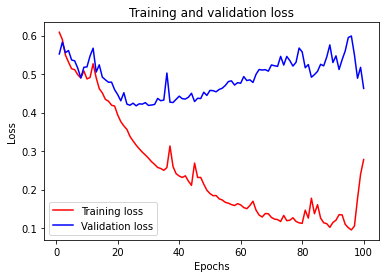

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

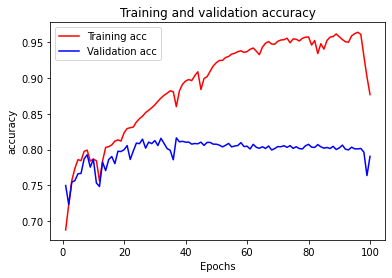

In [ ]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 6.예측

In [ ]:
def yes_or_no(sentence):
  tensor = []

  
  tensor.append(sp.EncodeAsIds(sentence))
  tensor = keras.preprocessing.sequence.pad_sequences(tensor, value = 0, padding = 'pre')
  x = model.predict(tensor)[0][0]
#   print("확률 : ", x)
#   print(type(x))

  if x[0] >= 0.5:
    return '긍정'
  else:
    return '부정'

In [ ]:
sent = input()
print("영화 감성 분류 \n")
print("감성 분석 결과 : ", yes_or_no(sent))

즐거운 영화.
영화 감성 분류 

감성 분석 결과 :  긍정


# 내용 총 정리

## 1.데이터 준비
1.코퍼스 준비
- 학습 데이터
- 시험 데이터
2.단어장 만들 데이터 준비

## 2.데이터 전처리
1.정규 표현식으로 걸러내기

2.중복제거 - drop_duplicates(subset=적용할 컬럼명, inplace=True)

3.결측치 제거 - dropna()

4.불용어 제거 - 반드시 원래 데이터 형태로 반환 해야한다.

## 3.SentencePieceProcessor
1.학습시키기 - SentencePieceTrainer

2.vocab 생성

## 4.토큰화
1.EncodeAsIds: ids으로 tokenize 후 정수화 - 리스트.append(sp.EncodeAsIds(문장))


2.vocab 불러오기

3.서브 워드 만들기 - for idx, line in enumerate(vocab):

4.tesor 생성 - tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

## 5.모델링
- X_train = tensor_train
- y_train = train_data['label']
- X_test = tensor_test
- y_test = test_data['label']
- 
- Sequential()
- Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
- LSTM(64, return_sequences=True))
- Dense(32, activation='relu'))
- Dense(1, activation='sigmoid'))
-
- model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])*이탤릭체 텍스트*